# Wine Quality GAN
## Created 22-Oct-2024 Mark A. Goforth, Ph.D.

### Purpose
This Jupyter notebook is designed to create a GAN Generative Adversarial Network from the Wine Quality dataset. The GAN can be used to generate fake data that looks like the original with the same statistical distributions.

### Description of GANs
GANs can be used to create new data that resembles the training dataset. GANs are made up of two different neural networks that are trained and pit against each other. One network is used for encoding into latent vectors, and the other network is used for decoding.

A GAN is called adversarial because it trains two different networks and pits them against each other. One network generates new data by taking an input data sample and modifying it as much as possible. The other network tries to predict whether the generated data output belongs in the original dataset. In other words, the predicting network determines whether the generated data is fake or real. The system generates newer, improved versions of fake data values until the predicting network can no longer distinguish fake from original.

For additional information, see https://aws.amazon.com/what-is/gan/
https://realpython.com/generative-adversarial-networks/

### General Steps for Approach
1. Download data
2. Prepare data for training
3. Model Building
4. Model Validation


# Install any necessary python packages

In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

# Import Libraries

In [82]:
import os
from datetime import datetime

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import kagglehub

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

# Download latest dataset version

In [53]:
pathstr = kagglehub.dataset_download("adarshde/wine-quality-dataset")
print("Path to dataset files:", pathstr)
df = pd.read_csv(pathstr+'/winequality-dataset_updated.csv')

Path to dataset files: /Users/Mark/.cache/kagglehub/datasets/adarshde/wine-quality-dataset/versions/3


In [54]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.3,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.2,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1999 non-null   float64
 1   volatile acidity      1999 non-null   float64
 2   citric acid           1999 non-null   float64
 3   residual sugar        1999 non-null   float64
 4   chlorides             1999 non-null   float64
 5   free sulfur dioxide   1999 non-null   float64
 6   total sulfur dioxide  1999 non-null   float64
 7   density               1999 non-null   float64
 8   pH                    1999 non-null   float64
 9   sulphates             1999 non-null   float64
 10  alcohol               1999 non-null   float64
 11  quality               1999 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 187.5 KB


In [56]:
# make all the columns the same datatype
df['quality'] = df['quality'].astype('double')

In [202]:
df.describe().T.style.background_gradient(axis=0, cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1999.000000,8.670335,2.240023,4.600000,7.100000,8.000000,9.900000,15.900000
volatile acidity,1999.000000,0.541773,0.180381,0.120000,0.400000,0.530000,0.660000,1.580000
citric acid,1999.000000,0.246668,0.181348,0.000000,0.110000,0.200000,0.385000,1.000000
residual sugar,1999.000000,3.699090,3.290201,0.900000,2.000000,2.300000,3.460000,15.990000
chlorides,1999.000000,0.075858,0.048373,0.010000,0.056000,0.075000,0.086000,0.611000
free sulfur dioxide,1999.000000,20.191096,15.642224,1.000000,9.000000,16.000000,27.000000,72.000000
total sulfur dioxide,1999.000000,52.617809,37.051121,6.000000,24.000000,42.000000,73.000000,289.000000
density,1999.000000,0.996477,0.002110,0.990070,0.995265,0.996600,0.997800,1.003690
pH,1999.000000,3.290140,0.274297,2.340000,3.180000,3.300000,3.420000,4.160000
sulphates,1999.000000,0.949465,0.780523,0.330000,0.560000,0.650000,0.840000,3.990000


# Prepare data for training

In [85]:
sklss = StandardScaler()
npsscale = sklss.fit_transform(df) 
print(type(npsscale))
npsscale

<class 'numpy.ndarray'>


array([[-0.61190356,  0.87740187, -1.36053581, ..., -0.49910432,
        -0.92813235, -0.50811687],
       [-0.38863571,  1.87554204, -1.36053581, ..., -0.3453227 ,
        -0.63607409, -0.50811687],
       [-0.38863571,  1.21011526, -1.13990987, ..., -0.3837681 ,
        -0.63607409, -0.50811687],
       ...,
       [ 1.04027849,  1.0992108 , -0.58834503, ..., -0.03775945,
        -0.92813235,  1.08517823],
       [ 2.82642123,  0.43378402, -0.31256261, ..., -0.24280161,
        -1.51224885,  0.28853068],
       [-1.63893564, -0.61980837, -0.64350151, ..., -0.62725567,
        -1.2201906 ,  1.08517823]])

In [86]:
train_dataset = torch.tensor(npsscale)
train_dataset = train_dataset.type(torch.DoubleTensor)

In [164]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Build GAN model

In [165]:
# Discriminator
D = nn.Sequential(
    nn.Linear(12, 16),
    nn.LeakyReLU(0.2),
    nn.Linear(16, 8),
    nn.LeakyReLU(0.2),
    nn.Linear(8, 1),
    # nn.Sigmoid()
)

In [166]:
# Generator
latent_dim = 10
G = nn.Sequential(
    nn.Linear(latent_dim, 8),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(8, momentum=0.7),
    nn.Linear(8, 16),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(16, momentum=0.7),
    nn.Linear(16, 12),
    nn.Tanh()
)

In [167]:
# Set device
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [168]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [171]:
# Training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1, dtype=torch.double).to(device)
zeros_ = torch.zeros(batch_size, 1, dtype=torch.double).to(device)

# save losses
d_losses = []
g_losses = []

# for epoch in range(200):
for epoch in range(100):
    # for inputs, _ in data_loader:
    for inputs in data_loader:
    
        # don't need targets
        
        # reshape and move to GPU
        n = inputs.size(0)
        inputs = inputs.reshape(n, 12).to(device)
        
        # set ones and zeros to correct size
        ones = ones_[:n]
        zeros = zeros_[:n]
        
        ###########################
        ### Train discriminator ###
        ###########################
        
        # real inputs
        real_outputs = D(inputs)
        d_loss_real = criterion(real_outputs, ones)
        
        # fake inputs
        noise = torch.randn(n, latent_dim).to(device)
        fake_data = G(noise)
        fake_outputs = D(fake_data)
        d_loss_fake = criterion(fake_outputs, zeros)
        
        # gradient descent step
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #######################
        ### Train generator ###
        #######################
        
        # do it twice:
        for _ in range(2):
            # fake images
            noise = torch.randn(n, latent_dim).to(device)
            fake_data = G(noise)
            fake_outputs = D(fake_data)
        
            # reverse the labels!
            g_loss = criterion(fake_outputs, ones)
        
            # gradient descent step
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
        
        # save losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        
    ### print and save things ###
    print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
        
    # save fake data to view later
    # print(fake_data)
    

Epoch: 0, d_loss: 0.680147628391081, g_loss: 0.7030111549131346
tensor([[ 0.9368,  0.9991, -0.9996,  0.9999, -0.9989,  0.9993,  0.3750,  0.8315,
         -0.9682,  0.8474,  0.9732, -0.9948],
        [ 0.9785, -0.9850,  0.9999, -0.9854,  0.9948, -0.9995,  0.8779,  0.9993,
         -0.3308, -0.9432, -1.0000,  0.4793],
        [ 0.9259, -0.9987,  0.9926, -0.8471,  0.1675, -0.9466, -0.7366, -0.2397,
         -0.8519, -0.8940, -0.0674,  0.8293],
        [ 0.7890, -0.9978,  0.9671, -0.1075, -0.7428, -0.4826, -0.7278, -0.6670,
         -0.8109, -0.5392,  0.9524,  0.8198],
        [ 0.9940, -0.9998,  0.9996, -0.8931,  0.2796, -0.9916,  0.5746,  0.9308,
         -0.9583, -0.9477, -0.9911,  0.5375],
        [ 0.9847, -0.9888,  0.9996,  0.0351,  0.7531, -0.9421,  0.9954,  0.9225,
         -0.9573,  0.2890, -0.9727,  0.9489],
        [ 0.1149,  0.9336,  0.8980,  0.0493,  0.9842, -0.9329,  0.9812,  0.8870,
          0.6866,  0.8000, -0.9887,  0.3815],
        [-0.3810,  0.9959,  0.7426,  0.6011,  0

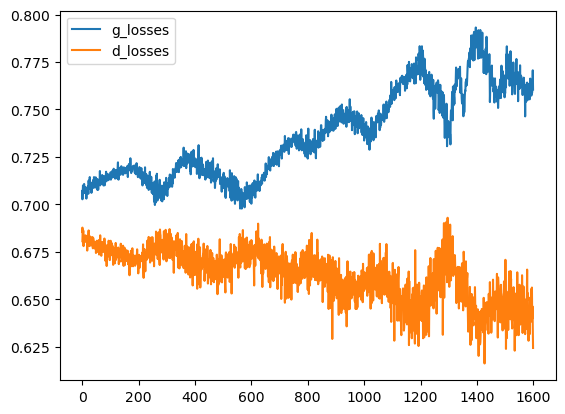

In [172]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

# Model Validation
## View generated fake data and compare with real data original distributions

In [176]:
# transform fake data back into original data ranges
fake_data_transform_back = sklss.inverse_transform(fake_data.detach().numpy())

In [189]:
np.set_printoptions(edgeitems=30,linewidth=100000)
print(fake_data_transform_back)

[[ 6.432  0.711  0.073  0.951  0.124 33.342 89.359  0.994  3.38   1.277  9.308  4.44 ]
 [10.903  0.714  0.329  2.503  0.042  5.52  16.559  0.998  3.069  0.216  9.99   6.811]
 [10.909  0.692  0.427  5.038  0.029  6.116 16.752  0.998  3.027  0.362 12.023  6.892]
 [10.886  0.379  0.427  3.455  0.034  7.422 15.696  0.998  3.13   0.212 12.036  6.884]
 [ 9.666  0.483  0.327  2.227  0.056 24.168 36.599  0.998  3.07   0.423 10.575  6.113]
 [10.91   0.722  0.066  6.95   0.036  4.553 15.577  0.999  3.564  0.184  9.302  4.383]
 [ 6.431  0.624  0.223  0.687  0.124 35.392 89.65   0.995  3.278  1.291  9.305  4.485]
 [ 6.431  0.361  0.405  0.412  0.124 35.81  89.658  0.994  3.557  1.656  9.418  4.384]
 [10.893  0.72   0.307  3.586  0.036  9.21  19.718  0.998  3.035  0.46  11.624  6.878]
 [10.892  0.417  0.426  3.578  0.05   5.975 15.631  0.999  3.276  0.189 11.941  6.824]
 [10.91   0.722  0.065  6.988  0.027 35.825 89.655  0.997  3.016  1.73  12.041  6.883]
 [10.052  0.361  0.428  3.462  0.03  34.041

In [199]:
pd.set_option('display.max_columns', 200)
index = ['Row'+str(i) for i in range(1, len(fake_data_transform_back)+1)]
dffake = pd.DataFrame(data=fake_data_transform_back, index=index, columns=df.columns )
print(dffake)

       fixed acidity  volatile acidity  citric acid  residual sugar  \
Row1        6.431659          0.710811     0.073024        0.950978   
Row2       10.902623          0.713749     0.329124        2.502837   
Row3       10.909474          0.691925     0.426704        5.038347   
Row4       10.886367          0.379061     0.427306        3.454892   
Row5        9.665773          0.482620     0.326924        2.227112   
...              ...               ...          ...             ...   
Row75       6.430894          0.361438     0.427895        1.059449   
Row76       6.432220          0.721799     0.067508        1.443108   
Row77       7.026632          0.721366     0.065798        2.073236   
Row78       6.433691          0.617973     0.121316        1.078161   
Row79       6.431951          0.721726     0.067730        1.392578   

       chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Row1    0.123805            33.342264             89.359186  0.994479   
R

## fake generated data

In [198]:
dffake.describe().T.style.background_gradient(axis=0)

,count,mean,std,min,25%,50%,75%,max
fixed acidity,79.000000,8.730459,2.031609,6.430873,6.434123,9.439652,10.889568,10.909798
volatile acidity,79.000000,0.574095,0.156375,0.361438,0.373264,0.678401,0.718759,0.722109
citric acid,79.000000,0.246829,0.160908,0.065372,0.071822,0.295070,0.420598,0.427971
residual sugar,79.000000,2.711557,1.989413,0.412380,1.091165,2.263940,3.519932,6.988467
chlorides,79.000000,0.077072,0.038578,0.027497,0.035879,0.080039,0.118349,0.124219
free sulfur dioxide,79.000000,19.233290,12.557804,4.552784,6.045525,17.542157,33.250246,35.828659
total sulfur dioxide,79.000000,49.289979,33.656261,15.576570,15.949908,36.599087,89.261513,89.659661
density,79.000000,0.996685,0.001640,0.994368,0.994838,0.997210,0.998242,0.998586
pH,79.000000,3.270029,0.220759,3.016064,3.056877,3.218421,3.535858,3.564363
sulphates,79.000000,0.647563,0.530677,0.173427,0.236526,0.406854,0.891522,1.729792


## original real data distributions

In [201]:
df.describe().T.style.background_gradient(axis=0, cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1999.000000,8.670335,2.240023,4.600000,7.100000,8.000000,9.900000,15.900000
volatile acidity,1999.000000,0.541773,0.180381,0.120000,0.400000,0.530000,0.660000,1.580000
citric acid,1999.000000,0.246668,0.181348,0.000000,0.110000,0.200000,0.385000,1.000000
residual sugar,1999.000000,3.699090,3.290201,0.900000,2.000000,2.300000,3.460000,15.990000
chlorides,1999.000000,0.075858,0.048373,0.010000,0.056000,0.075000,0.086000,0.611000
free sulfur dioxide,1999.000000,20.191096,15.642224,1.000000,9.000000,16.000000,27.000000,72.000000
total sulfur dioxide,1999.000000,52.617809,37.051121,6.000000,24.000000,42.000000,73.000000,289.000000
density,1999.000000,0.996477,0.002110,0.990070,0.995265,0.996600,0.997800,1.003690
pH,1999.000000,3.290140,0.274297,2.340000,3.180000,3.300000,3.420000,4.160000
sulphates,1999.000000,0.949465,0.780523,0.330000,0.560000,0.650000,0.840000,3.990000
